<a href="https://colab.research.google.com/github/burcia1711/word-order-simulation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTS AND OTHER FUNCTIONALITIES**

In [1]:
import random
from copy import deepcopy 
from numpy.random import normal
import numpy
from scipy.stats import beta
from scipy.special import logsumexp
from math import log, log1p, exp

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')



# **constants**

In [2]:
personalities = ['F', 'S'] #F for flexible, S for stubborn

sentence_type = ['reversible', 'irreversible']
sentence_weights = [7, 3]

basic_orders = ['SOV', 'SVO', 'OSV', 'OVS', 'VSO', 'VOS']

start = 0
stop = 2

starting_irrev_bias = [10, 7, 1, 1, 1, 1]
starting_rev_bias = [3, 5, 1, 1, 1, 1]



## **LANGUAGE**

There are different types of languages (logical, agglutinative, etc.). So, if a languagua evolve one of them, then there will be consequences accordingly.


In [3]:
class Language:
  def __init__(self, typ, age, pop):
    self.typ = typ
    self.age = age
    self.population = pop

## general functions / utils

## **AGENTS**

Agents are humans, they have:

*   generation number (1st, 2nd, 10th, etc.) 
*   personality type (stubborn or flexible)
*   is affected by any other languge (1 is for True, 0 is for False)



In [4]:
class Agent:
# children
  def __init__(self, g, p, l, mother, father):
    self.generation = g
    self.personality = p
    self.ling = l
    self.irrev_weights = self.set_irrev_weights()
    self.rev_weights = self.set_rev_weights()

# first gen
  def __init__(self, g, p, l):
    self.generation = g
    self.personality = p
    self.ling = l
    self.irrev_weights = starting_irrev_bias
    self.rev_weights = starting_rev_bias

  def new_weight(self, order):
    weight = []
    for i in basic_orders:
       if order == i:
         weight.append(1)
       else:
         weight.append(0)
    return weight

  def list_summation(self, l1, l2):
    res_lt = [l1[x] + l2[x] for x in range (len(l1))]
    return res_lt

  def is_stubborn(self):
    return self.personality == 'S'
  
  def set_irrev_weights(self):
    (self.mother.irrev_weights + self.father.irrev_weights)/2

  def set_rev_weights(self):
    (self.mother.rev_weights + self.father.rev_weights)/2

  def add_rev_weights(self, word_order):
    if(self.is_stubborn()):
      self.rev_weights = self.list_summation(self.rev_weights, self.new_weight(word_order))
    else:
      multiplied_list = [element * 2 for element in self.new_weight(word_order)]
      self.rev_weights = self.list_summation(self.rev_weights, multiplied_list)

  def add_irrev_weights(self, word_order):
    if(self.is_stubborn()):
      self.irrev_weights = self.list_summation(self.irrev_weights, self.new_weight(word_order))
    else:
      multiplied_list = [element * 2 for element in self.new_weight(word_order)]
      self.irrev_weights = self.list_summation(self.irrev_weights, multiplied_list)

In [5]:
#create agents (humans :D)
def make_agent(agent):
    return [agent.generation, agent.personality, agent.ling, agent.irrev_weights, agent.rev_weights]

## **POPULATIONS**

Populations are based on number of people (N) in a particular generation

In [6]:
def make_agents(N, G):
    gen = G
    population = []

    for i in range(N): 
        l = random.randint(0,1)
        p = random.randint(0,1)
        agent = Agent(gen, personalities[p], l)
        population.append(agent)

    for obj in population:
      print(obj.rev_weights)

    return population


# Check that this works by making a population of 8 agents

make_agents(8,0)


[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]


In [7]:
def create_population(starting_pop, n_generations):
  people_in_population = []
  for i in range(n_generations): 
    if i == 0:
      people_in_population.extend(make_agents(starting_pop, i))
    else:
      people_in_population.extend(make_agents(int(len(people_in_population)*(random.randrange(start, stop+1)+0.3)), i))
    print(len(people_in_population))

  return(people_in_population)
    
population_test = create_population(5, 1)
  

[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
5


## **WORD ORDER and SENTENCE GENERATION**



In [8]:
from collections import Counter
import pandas

def plot_freq_list(l):
  count = Counter(sorted(l))
  df = pandas.DataFrame.from_dict(count, orient='index')
  df.plot(kind='bar')


In [9]:
def generate_word_order_list(order_list, weight, n):
  return random.choices(order_list, weights = weight, k = n)

In [10]:
WORD_ORDER_LIST = []

WORD_ORDER_LIST = generate_word_order_list(basic_orders,[10, 7, 1, 1, 1, 1], 100)
#WORD_ORDER_LIST

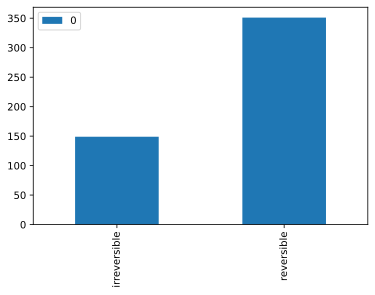

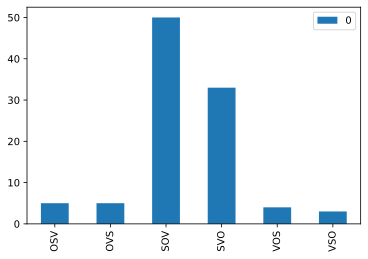

In [11]:
def make_utterance(n):
  return random.choices(sentence_type, weights =sentence_weights, k = n)

utterence_list =[] 
utterence_list = make_utterance(500)

plot_freq_list(utterence_list)
plot_freq_list(WORD_ORDER_LIST)

# **COMMUNICATIONS**

In [21]:
def select_two_random_persons(population):
  people_selected = []
  
  agent1_index = random.randint(0, len(population)-1)
  agent2_index = random.randint(0, len(population)-1)

  while agent1_index == agent2_index:
    agent2_index = random.randint(0, len(population))

  print(agent1_index)
  print(agent2_index)

  people_selected.append(population[agent1_index])
  people_selected.append(population[agent2_index])
  #print(people_selected, sentence_list)

  return people_selected


In [18]:
def select_n_random_persons(n_people, population):
  people_selected = []
  people_indices = random.sample(range(0, len(population)-1), n_people)
  print(people_indices)
  people_selected = [population[i] for i in people_indices]
  
  return people_selected

In [14]:
s = select_n_random_persons(4, population_test)
s[3].irrev_weights

[10, 7, 1, 1, 1, 1]

In [22]:
#two people communicate with n sentences
def two_people_communicate(n, population):  # n is the number of sentences for the communication, population is the given population
  sentence_list = make_utterance(n) # create n sentence type list (rev or irrev)
  selected_people = select_two_random_persons(population) # select two random people in the population

  for i in range(n):
    speaker_index = random.randint(0, 1)
    listener_index = not speaker_index

    if sentence_list[i] == 'irrev':
      spoken_word_order = generate_word_order_list(basic_orders, selected_people[speaker_index].irrev_weights, 1) # generate a word order for given sentence
      #update listener
      selected_people[listener_index].add_irrev_weights(spoken_word_order)
    
    else:
      spoken_word_order = generate_word_order_list(basic_orders, selected_people[speaker_index].rev_weights, 1) # generate a word order for given sentence
      #update listener
      selected_people[listener_index].add_rev_weights(spoken_word_order)



In [23]:
two_people_communicate(25, population_test)

1
4


In [25]:
print(population_test[1].rev_weights)
print(population_test[1].irrev_weights)
print(population_test[4].rev_weights)
print(population_test[4].irrev_weights)

[3, 5, 1, 1, 1, 1]
[10, 7, 1, 1, 1, 1]
[3, 5, 1, 1, 1, 1]
[10, 7, 1, 1, 1, 1]


## Network types



*   **Vertical network** (1-1 communication)
*   **Circular** (1-1 but circular & continuous)
*   **Chain** (like vertical but many go on)
*   **Wheel** (a center, others communicate with that center simultaneously)
*   **Star** (all connected & comunicate simultaneously)




# **SIMULATIONS**

**Parameters:**


*   Different networks
*   Different frequencies of utterance creation (communication)
*   Size of population
*   Different language types
*   Different starting bias
*   Number of generations



In [17]:
# def choose_utterance(agent):   # sample from a normal distribution with SD=0.25 and mean of the teacher
#    agent_utterance=normal(agent[0],.25)
#    return agent_utterance

# Let's check that this works
# You can run this multiple times to see different chosen utterances for different agents

# pop=make_population(4)
# vowel = choose_utterance(pop[0])
# print("The agent's mean was", pop[0][0])
# print("The agent's chosen utterance is", vowel)